# Hand sign classification

## Import

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import kagglehub
import os
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms


### CONSTANTS

In [17]:
IMG_SIZE = 224
BATCH_SIZE = 32

## prepare the dataset

In [18]:

# 1. Download dataset with kagglehub
path = kagglehub.dataset_download("jeyasrisenthil/hand-signs-asl-hand-sign-data")
print("Path to dataset files:", path)

# The dataset unpacks into something like: <path>/asl_dataset/<class>/*.jpg
# Let's point ImageFolder to the root that contains the class folders
data_root = os.path.join(path, "DATASET")  # adjust if you see an extra nested folder

# 2. Define transforms
full_dataset = datasets.ImageFolder(root=data_root, transform=transforms.ToTensor())
print("Total images:", len(full_dataset))
print("Classes:", full_dataset.classes)


Path to dataset files: /home/tommaso/.cache/kagglehub/datasets/jeyasrisenthil/hand-signs-asl-hand-sign-data/versions/1
Total images: 900
Classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [19]:
test_ratio = 0.2
test_size = int(len(full_dataset) * test_ratio)
train_size = len(full_dataset) - test_size

train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

print("Train samples:", len(train_dataset))
print("Test samples:", len(test_dataset))

Train samples: 720
Test samples: 180


In [20]:
def compute_mean_std(dataset):
    # accumulate sum and sum of squares
    loader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=2)
    mean = 0.0
    sq_mean = 0.0
    n_samples = 0
    for imgs, _ in loader:
        batch_samples = imgs.size(0)
        imgs = imgs.view(batch_samples, imgs.size(1), -1)  # [B, C, H*W]
        mean += imgs.mean(2).sum(0)
        sq_mean += (imgs ** 2).mean(2).sum(0)
        n_samples += batch_samples
    mean /= n_samples
    sq_mean /= n_samples
    std = (sq_mean - mean ** 2).sqrt()
    return mean, std

mean, std = compute_mean_std(train_dataset)
print("Training set mean:", mean)
print("Training set std:", std)

Training set mean: tensor([0.8967, 0.8332, 0.8409])
Training set std: tensor([0.1566, 0.2472, 0.2410])


In [21]:
img_size = IMG_SIZE

train_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist())
])

test_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist())
])

# Update datasets with transforms
train_dataset.dataset.transform = train_transforms
test_dataset.dataset.transform = test_transforms

# -------- 5️⃣ Create DataLoaders --------
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)


/tmp/ipykernel_610181/189702565.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = img * torch.tensor(std).view(1,1,3) + torch.tensor(mean).view(1,1,3)


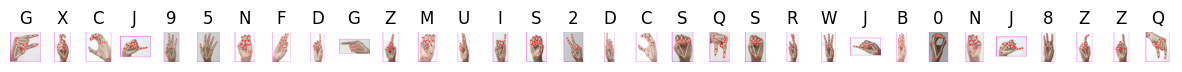

In [22]:
def show_batch(loader, classes):
    imgs, labels = next(iter(loader))
    imgs = imgs.permute(0,2,3,1)  # CHW -> HWC
    fig, axes = plt.subplots(1, len(imgs), figsize=(15,3))
    for ax, img, lbl in zip(axes, imgs, labels):
        # Undo normalization for visualization
        img = img * torch.tensor(std).view(1,1,3) + torch.tensor(mean).view(1,1,3)
        img = img.clamp(0,1).numpy()
        ax.imshow(img)
        ax.set_title(classes[lbl])
        ax.axis("off")
    plt.show()

show_batch(train_loader, full_dataset.classes)

## fine-tune the model